In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.impute import SimpleImputer

df_birds = pd.read_csv("blackbird.csv")

print("setup and imports complete")

setup and imports complete


In [36]:
print("data frame shape: ",np.shape(df_birds))
df_birds.head()

data frame shape:  (4123, 10)


,Scheme,Ring number,Age,Sex,Wing,Weight,Day,Month,Year,Time
0,NOS,7453852,A,M,133.0,95.0,21,12,2006,14
1,BLB,23Z56852,A,M,134.0,106.0,25,11,2012,9
2,SFH,A559350,A,M,135.0,125.0,29,1,1994,9
3,SFH,A559350,A,M,135.0,113.0,5,2,1994,10
4,SFH,A559350,A,M,135.0,111.0,12,2,1994,8


In [37]:
#no data is missing
def missingDataCount(df):
    missing_val_count = df.isnull().sum()
    missing_val_count.sort_values(ascending=False,inplace=True)
    total_cells = np.product(df.shape)
    total_missing = missing_val_count.sum()
    print (missing_val_count[0:10])
    print ("percent missing overall (out of 100) = ",(total_missing/total_cells) * 100)

missingDataCount(df_birds)

Wing           251
Weight          40
Time             0
Year             0
Month            0
Day              0
Sex              0
Age              0
Ring number      0
Scheme           0
dtype: int64
percent missing overall (out of 100) =  0.7057967499393646


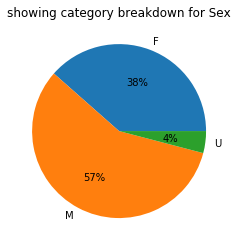

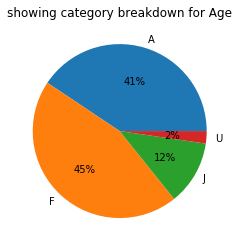

In [38]:
def categoryCheck(df,label):
    value_count = df[label].value_counts()
    df_values_counts = value_count.rename_axis('unique_values').reset_index(name='counts')
    categ_sums = df_values_counts.counts.groupby(df_values_counts.unique_values).sum()
    plt.pie(categ_sums,labels=categ_sums.index, autopct='%1.0f%%')
    plt.title("showing category breakdown for {0}".format(label))
    plt.show()

categoryCheck(df_birds,"Sex")
categoryCheck(df_birds,"Age")

In [58]:
my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
col_holder = df_birds.columns
df_birds = pd.DataFrame(my_imputer.fit_transform(df_birds.))
df_birds.columns = col_holder
#my_imputer.fit_transform(df_birds['Wing'])
#my_imputer.fit_transform(df_birds[['Weight']])

missingDataCount(df_birds)

AttributeError: 'DataFrame' object has no attribute 'dtype'

ValueError: cannot convert float NaN to integer

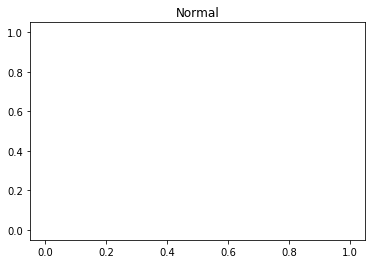

In [54]:
blackbird_features = ['Scheme','Ring number','Age','Sex','Wing','Weight','Day','Month','Year','Time']
blackbird_numeric_features = ['Wing','Weight']

for feature in blackbird_numeric_features:
    x = df_birds[feature]
    plt.figure(1); plt.title('Normal')
    sns.distplot(x, kde=True, fit=stats.norm)
    plt.show()

In [39]:
#change the categorical letters to discrete nominal and ordinal values respectively
#this is so they will work properly with models and such later on
le = LabelEncoder()
le.fit(["F", "M", "U"])
le.transform(df_birds['Sex'])
le = LabelEncoder()
le.fit(["A","U","J","F"])
le.transform(df_birds['Age'])

blackbird_numeric_features = ['Wing','Weight']
scaler = StandardScaler()
scaler.fit(df)

array([0, 0, 0, ..., 2, 2, 2])

In [43]:
def spearman(frame, features,correlate_for):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[correlate_for], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    print(spr)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

def pearson(frame, features,correlate_for):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['pearson'] = [frame[f].corr(frame[correlate_for], 'pearson') for f in features]
    spr = spr.sort_values('pearson')
    print(spr)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='pearson', orient='h')

       feature  spearman
2          Age -0.413126
7        Month -0.142617
9         Time -0.008561
6          Day -0.004797
1  Ring number -0.002263
0       Scheme  0.051619
8         Year  0.080540
3          Sex  0.410872
5       Weight  0.411095
4         Wing  1.000000


TypeError: unsupported operand type(s) for /: 'str' and 'int'

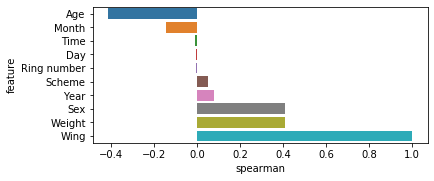

In [44]:
#do spearman, pearsons and pmcc 
spearman(df_birds,blackbird_features,'Wing')
pearson(df_birds,blackbird_features,'Wing')